In [7]:
%load_ext autoreload
%autoreload 2

import random
import time
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"


import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW, Adam

import activation
import cpn_model
import config
import lesion
import michaels_load
import mRNN
import observer
import stim
import stim_model
import utils


OBSERVER_TYPE = observer.ObserverType.gaussian
STIMULATION_TYPE = stim.StimulationType.gaussian_exp
CPN_ACTIVATION_TYPE = activation.ActivationType.Tanh
EN_ACTIVATION_TYPE = activation.ActivationType.Tanh
LESION_TYPE = lesion.LesionType.connection
OBS_OUT_DIM = 20
OBS_SIGMA = 1.75
NUM_STIM_CHANNELS = 16
STIM_SIGMA = 2.175
BATCH_SIZE = 128
KFOLDS = 5
CUDA = torch.device(0)

LESION_ARGS = ([
    # No F5->M1
    (1, 2, 0, 1),
    # No M1->F5
    (0, 1, 1, 2),
],)

observer, stimulus, lesion_instance, en_activation, cpn_activation, \
        run_type_str, run_type_str_short, _ = config.get(observer_type=OBSERVER_TYPE,
                                              stimulation_type=STIMULATION_TYPE,
                                              lesion_type=LESION_TYPE,
                                              lesion_args=LESION_ARGS,
                                              en_activation_type=EN_ACTIVATION_TYPE,
                                              cpn_activation_type=CPN_ACTIVATION_TYPE,
                                              batch_size=BATCH_SIZE,
                                              num_stim_channels=NUM_STIM_CHANNELS,
                                              stim_sigma=STIM_SIGMA,
                                              obs_out_dim=OBS_OUT_DIM,
                                              obs_sigma=OBS_SIGMA,
                                              cuda=CUDA)


MODEL_OUT_DIR = "models"
LOG_OUT_DIR = "logs"

print("Run config:", run_type_str)
print(run_type_str_short)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Run config: gaussian20.1.75_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2)]_gaussianExp16.2.175_enActTanh_cpnActTanh
obsgaussian20_lesionconnection_stimgaussian_exp16_enActTanh_cpnActTanh


In [8]:
# Set up the Michaels mRNN

mike = mRNN.MichaelsRNN(init_data_path=michaels_load.get_default_path())

if CUDA:
    mike.cuda()
    
mike.set_lesion(lesion_instance)
mike.reset()

In [21]:
# Get the Michaels session data
dataset = mRNN.MichaelsDataset(michaels_load.get_default_path(), with_label=True,
                              cuda=CUDA)

probs = torch.ones(len(dataset)) / float(len(dataset))
holdout_count = int(len(dataset) / KFOLDS)
holdout_idxs = set([p.item() for p in probs.multinomial(num_samples=holdout_count)])

train = []
test = []
for idx in range(len(dataset)):
    if idx in holdout_idxs:
        test.append(dataset[idx])
    else:
        train.append(dataset[idx])

# We have two loaders, since they maintain a little bit of state,
# and we nest EN training inside CPN training
loader_train = DataLoader(
  train, batch_size=len(train), shuffle=True
)
loader_test = DataLoader(
  test, batch_size=len(test), shuffle=True
)


torch.Size([341, 1])


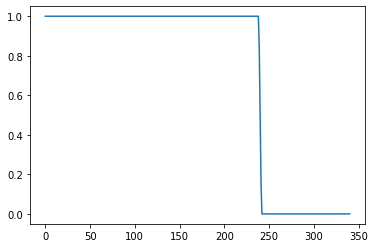

In [6]:
# Hold signal is in the last position
plt.plot(dataset[0][0][:, -1:].cpu().detach().numpy())
print(dataset[0][0][:, -1:].shape)
plt.show()

In [30]:
# Question: can we separate the classes before movement onset?

loss = nn.CrossEntropyLoss()
model = utils.LSTMModel(2*OBS_OUT_DIM, 42, num_neurons=3*OBS_OUT_DIM,
                       cuda=CUDA)

opt = AdamW(model.parameters(), lr=1e-3)#, weight_decay=0.04)
ll = 1

for param in mike.parameters():
    param.requires_grad=False

    
def unroll(model, mike, observer, din, shift=50, cuda=None):
    mike.reset()
    model.reset()
    
    dhold = din[:, :, -1:]
    batch_size = din.shape[0]
    steps = 250

    for tidx in range(steps):
        mike_in = din[:, tidx, :].T
        mike(mike_in)         
            
        if tidx < shift:
            cur_hold = torch.ones(din[:, tidx, -1:].shape)
            if cuda:
                cur_hold = cur_hold.cuda(cuda)
        else:
            cur_hold = din[:, tidx-shift, -1:]
            
        obs = mike.observe(observer)
        new_obs = torch.cat(obs[1:], axis=1)
        
        new_obs = new_obs * cur_hold
        
        pred = model(new_obs)
        
    return pred
        
eidx = 0
losses = []
test_losses = []
bail = False
while True:
    for batch in loader_train:
        if ll >= 1.6:
            for p in opt.param_groups:
                p['lr'] = 1e-3
        elif ll < 1.6:
            for p in opt.param_groups:
                p['lr'] = 1e-4
        elif ll < 1.3:
            for p in opt.param_groups:
                p['lr'] = 5e-5
        elif ll < 1:
            for p in opt.param_groups:
                p['lr'] = 3e-5
        
        din, trial_end, trial_len, dout, dlabel = batch
        batch_size = din.shape[0]
        opt.zero_grad() 
 
        pred = unroll(model, mike, observer, din, cuda=CUDA)
                
        la = loss(pred, dlabel)

        ll = la.item()
        la.backward()
        opt.step()
        losses.append(ll)
        
        correct = 0
        for x in range(batch_size):
            m = torch.argmax(pred[x, :])
            if m == dlabel[x]:
                correct += 1
                
        
        batch_test = next(iter(loader_test))
        din_test, trial_end_test, trial_len_test, dout_test, dlabel_test = batch_test
        batch_size_test = din_test.shape[0]
        pred_test = unroll(model, mike, observer, din_test, cuda=CUDA)
            
        rl = loss(pred_test, dlabel_test)
        rli = rl.item()
        test_losses.append(rli)
        
        correct_test = 0
        for x in range(batch_size_test):
            m = torch.argmax(pred_test[x, :])
            if m == dlabel_test[x]:
                correct_test += 1

        print(eidx, f"{correct}/{batch_size}", ll, f"test: {correct_test}/{batch_size_test}")
        
        if (correct / batch_size) >= 0.995:
            bail = True
            break
        
        
        eidx += 1
    if bail:
        break
        


7414 396/402 0.2493273764848709 test: 89/100
7415 395/402 0.244556725025177 test: 89/100
7416 395/402 0.2455032467842102 test: 89/100
7417 392/402 0.2476249486207962 test: 88/100
7418 397/402 0.2438620626926422 test: 89/100
7419 394/402 0.24471741914749146 test: 89/100
7420 396/402 0.24308139085769653 test: 87/100
7421 397/402 0.2454335242509842 test: 89/100
7422 395/402 0.24227258563041687 test: 89/100
7423 394/402 0.2418556958436966 test: 88/100
7424 396/402 0.2433449625968933 test: 88/100
7425 397/402 0.2407187670469284 test: 89/100
7426 394/402 0.2414681762456894 test: 88/100
7427 397/402 0.24078458547592163 test: 87/100
7428 395/402 0.24284479022026062 test: 90/100
7429 395/402 0.2409411519765854 test: 90/100
7430 394/402 0.24097010493278503 test: 87/100
7431 396/402 0.24209338426589966 test: 88/100
7432 395/402 0.23919391632080078 test: 89/100
7433 395/402 0.24031344056129456 test: 87/100
7434 395/402 0.23895978927612305 test: 87/100
7435 395/402 0.23973844945430756 test: 89/100


7594 397/402 0.2230483740568161 test: 89/100
7595 397/402 0.22327078878879547 test: 90/100
7596 395/402 0.2242918312549591 test: 89/100
7597 398/402 0.22367358207702637 test: 89/100
7598 397/402 0.22276917099952698 test: 89/100
7599 398/402 0.2228097915649414 test: 89/100
7600 397/402 0.22350957989692688 test: 91/100
7601 396/402 0.22364744544029236 test: 89/100
7602 397/402 0.22275711596012115 test: 89/100
7603 397/402 0.22246135771274567 test: 91/100
7604 397/402 0.2230711430311203 test: 89/100
7605 397/402 0.22399528324604034 test: 91/100
7606 395/402 0.22357648611068726 test: 89/100
7607 397/402 0.2223697155714035 test: 89/100
7608 397/402 0.22179247438907623 test: 90/100
7609 397/402 0.22192397713661194 test: 89/100
7610 397/402 0.22177748382091522 test: 89/100
7611 397/402 0.2216133177280426 test: 89/100
7612 397/402 0.22151164710521698 test: 89/100
7613 397/402 0.22137916088104248 test: 89/100
7614 397/402 0.22131210565567017 test: 89/100
7615 397/402 0.22125570476055145 test: 8

KeyboardInterrupt: 

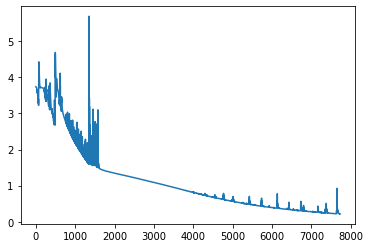

0.21581164002418518


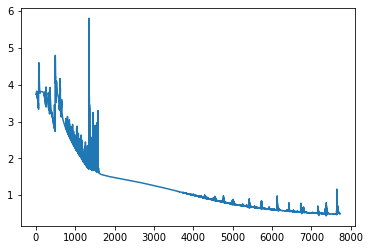

0.4385320544242859


In [31]:
plt.plot(losses)
plt.show()
print(min(losses))

plt.plot(test_losses)
plt.show()
print(min(test_losses))

89/100


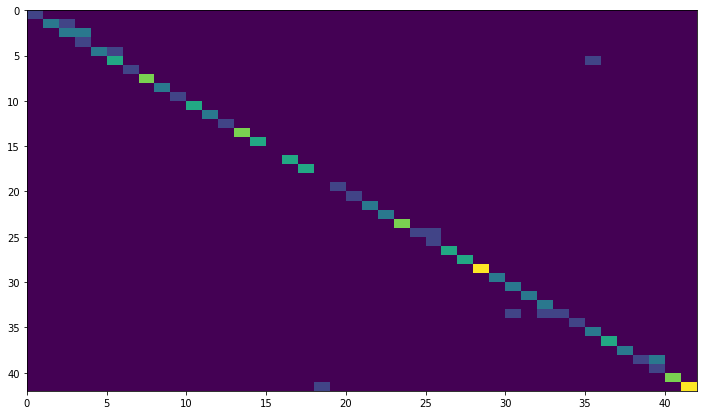

In [33]:
# Calc confusion matrix over test data set
din, trial_end, trial_len, dout, dlabel = next(iter(loader_test))

batch_size = din.shape[0]
steps = din.shape[1]

mike.reset()
model.reset()

pred = unroll(model, mike, observer, din, cuda=CUDA)


correct = 0
confusion_matrix = torch.zeros(42, 42)
for x in range(batch_size):
    m = torch.argmax(pred[x, :])
    if m == dlabel[x]:
        correct += 1
        
    confusion_matrix[dlabel[x], m] += 1.0
print(f"{correct}/{batch_size}")

#confusion_matrix /= confusion_matrix.sum(axis=1)

plt.figure(figsize = (12,7))
plt.gca().invert_yaxis()
plt.pcolormesh(confusion_matrix)